In [2]:
from notebooks.plots import *
from compoundeye import POLCompassDRA
from compoundeye.evaluation import evaluate
from compoundeye.geometry import fibonacci_sphere, angles_distribution
from environment import Sun, Sky, get_seville_observer
from world import load_routes, Hybrid
from sphere.transform import sph2vec, vec2sph, tilt
from code.compass import decode_sph
from net import CX

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

sun = Sun()
seville_obs = get_seville_observer()

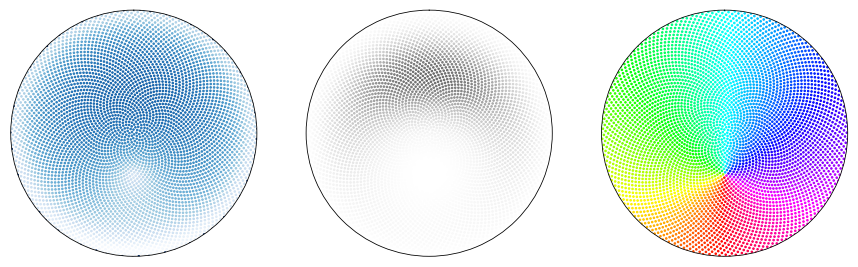

In [6]:
%matplotlib inline

samples = 5000

theta, phi = fibonacci_sphere(samples, 180)
sky = Sky(np.pi/6, np.pi)
y, p, a = sky(theta, phi)

plt.figure("sky", figsize=(15, 5))
plot_sky(phi, theta, y, p, a).show()

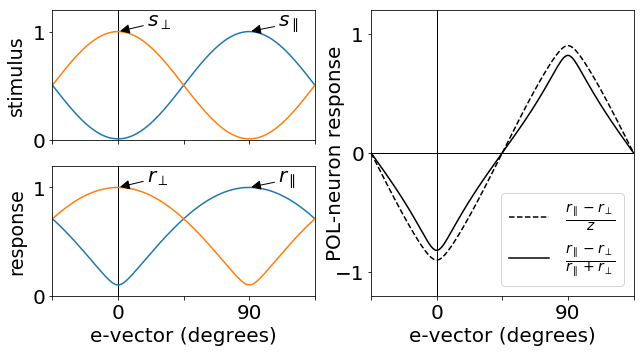

In [3]:
Y = 7.5  # light intensity
pol = .9  # degree of polarasation
e = np.linspace(-np.pi / 4, 3 * np.pi / 4, 361)  # e-vector orientation
act_func = np.sqrt  # activation function

s_1 = Y * (np.square(np.cos(e)) + np.square(np.sin(e)) * np.square(1. - pol))
s_2 = Y * (np.square(np.sin(e)) + np.square(np.cos(e)) * np.square(1. - pol))

r_1 = act_func(s_1)
r_2 = act_func(s_2)

z = act_func(Y)
r_z = (r_2 - r_1) / z
r_pol = (r_2 - r_1) / (r_2 + r_1)

plt.figure("photoreceptors", figsize=(9, 5))
plot_pol_neurons_rotating_linear_polariser(
    [np.rad2deg(e), s_1 / Y], [np.rad2deg(e), s_2 / Y],
    [np.rad2deg(e), r_1 / z], [np.rad2deg(e), r_2 / z],
    [np.rad2deg(e), r_z], [np.rad2deg(e), r_pol]).show()

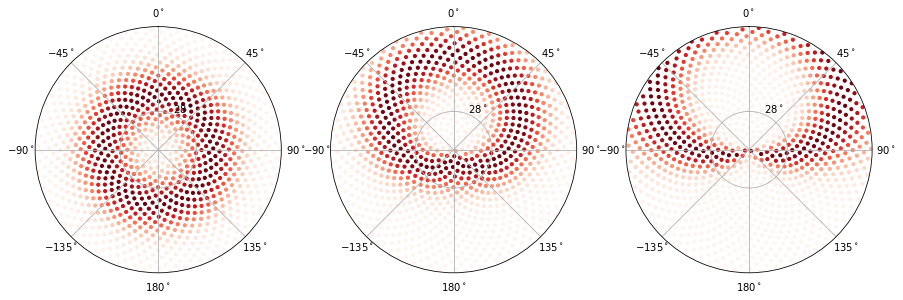

In [8]:
plt.figure("gate-ring", figsize=(15, 5))
plot_gate_ring(theta_t=np.deg2rad(0), subplot=131)
plot_gate_ring(theta_t=np.deg2rad(30), subplot=132)
plot_gate_ring(theta_t=np.deg2rad(60), subplot=133).show()

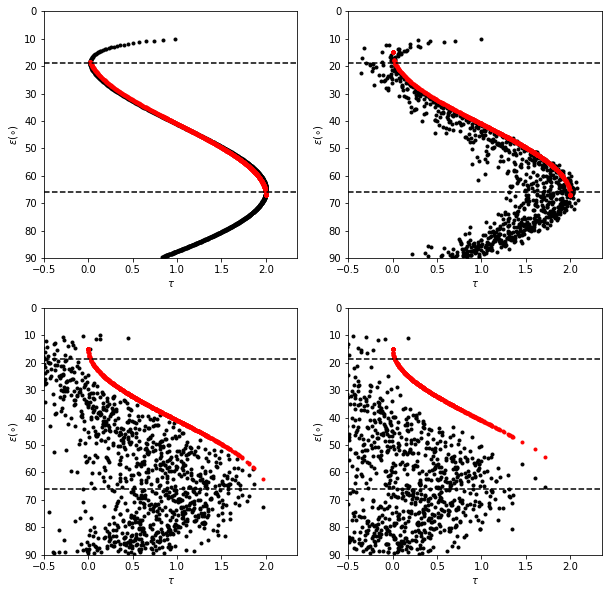

In [4]:
plt.figure("res2ele", figsize=(15, 15))
plot_res2ele(noise=0.00, subplot=221)
plot_res2ele(noise=0.06, subplot=222)
plot_res2ele(noise=0.26, subplot=223)
plot_res2ele(noise=0.43, subplot=224).show()

Error: 3.2521 +/- 0.1002 | N = 869


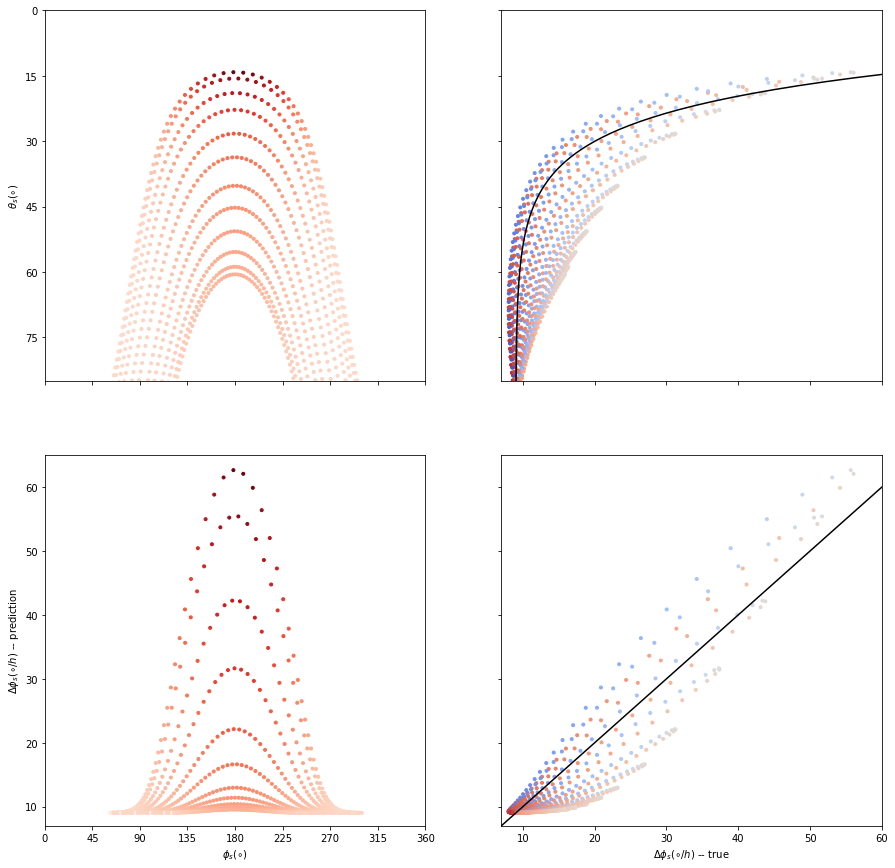

In [3]:
seville_obs.date = datetime.strptime("2018-06-21", "%Y-%m-%d")

plt.figure("ephemeris", figsize=(15, 15))
plot_ephemeris(seville_obs).show()

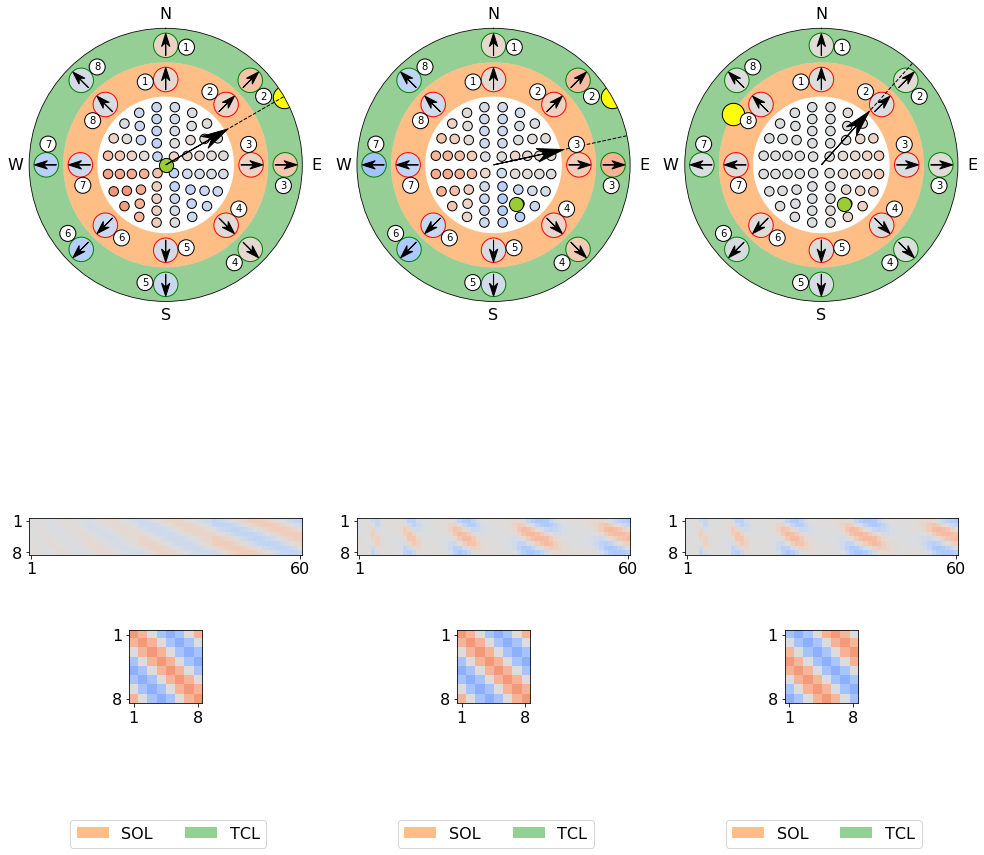

In [10]:
plt.figure("Step-by-step processing of the compass model", figsize=(15, 15))
params = evaluate(sun_azi=np.pi/3, sun_ele=np.pi/3, snap=True, tilting=False)
kwargs = {'subplot': 131}
plot_snapshot(*params, **kwargs)
params = evaluate(sun_azi=np.pi/3, sun_ele=np.pi/3, snap=True, tilting=(np.pi/9, 5*np.pi/6))
kwargs = {'subplot': 132}
plot_snapshot(*params, **kwargs)
params = evaluate(sun_azi=-np.pi/3, sun_ele=np.pi/4, snap=True, tilting=(np.pi/9, 5*np.pi/6), ephemeris=True)
kwargs = {'subplot': 133}
plot_snapshot(*params, **kwargs).show()

In [6]:
plt.figure("Accuracy", figsize=(15, 7.5))
plot_accuracy().show()

Minimum cost (10.47) for Sigma = 13.00, Shift = 39.00


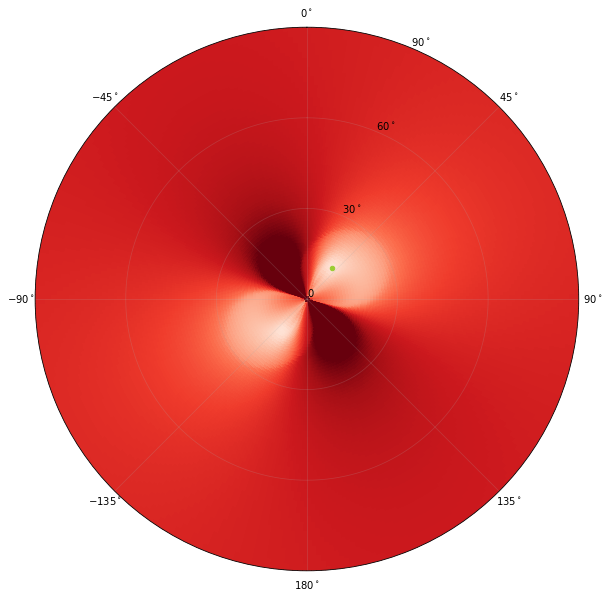

In [16]:
plt.figure("Gating parameters optimisation", figsize=(10, 10))
plot_gate_optimisation().show()

Tilt             overall              0 deg              30 deg             60 deg     
---------------------------------------------------------------------------------------
Mean cost    65.78 +/- 0.6289    0.63 +/- 0.0142    35.68 +/- 0.0083    104.01 +/- 0.0140


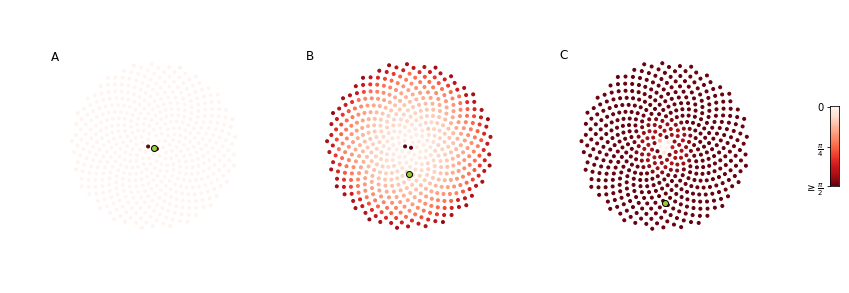

Tilt             overall              0 deg              30 deg             60 deg     
---------------------------------------------------------------------------------------
Mean cost    10.71 +/- 0.1622    0.47 +/- 0.0142    9.53 +/- 0.0040    13.16 +/- 0.0035


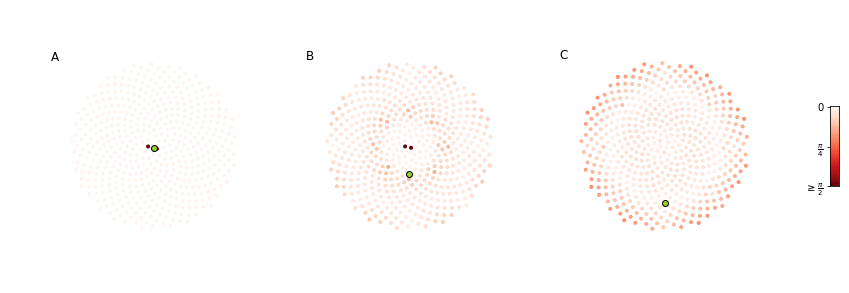

In [4]:
plt.figure("Not dealing with tilt", figsize=(15, 5))
plot_gate_cost(sigma=100.).show()
plt.figure("Dealing with tilt", figsize=(15, 5))
plot_gate_cost().show()

Minimum cost (9.55) for N = 336, Omega = 56.00
Mean omega 55.99 +/- 0.3367


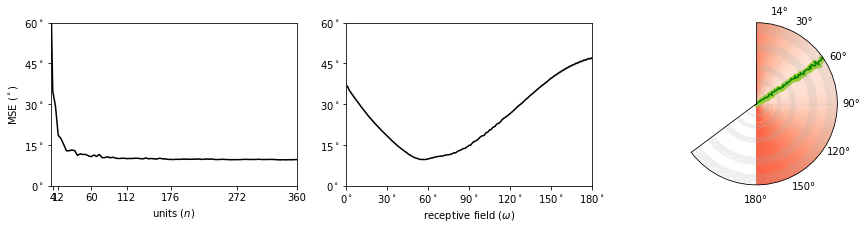

In [5]:
plt.figure("Structure optimisation", figsize=(15, 3))
plot_structure_optimisation().show()

2018/6/21 09:00:00


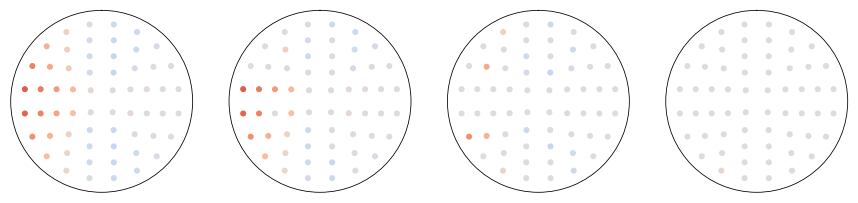

In [22]:
seville_obs.date = datetime.strptime("2018-06-21 9:00", "%Y-%m-%d %H:%M")
sun.compute(seville_obs)

sky = Sky(theta_s=np.pi / 2 - sun.alt, phi_s=sun.az)
dra = POLCompassDRA()

plt.figure("sky", figsize=(15, 3.5))
r_pol = dra(sky, noise=0.0)
plot_disturbance(dra.phi, dra.theta, r_pol, subplot=141)
r_pol = dra(sky, noise=0.33)
plot_disturbance(dra.phi, dra.theta, r_pol, subplot=142)
r_pol = dra(sky, noise=0.66)
plot_disturbance(dra.phi, dra.theta, r_pol, subplot=143)
r_pol = dra(sky, noise=0.99)
plot_disturbance(dra.phi, dra.theta, r_pol, subplot=144).show()

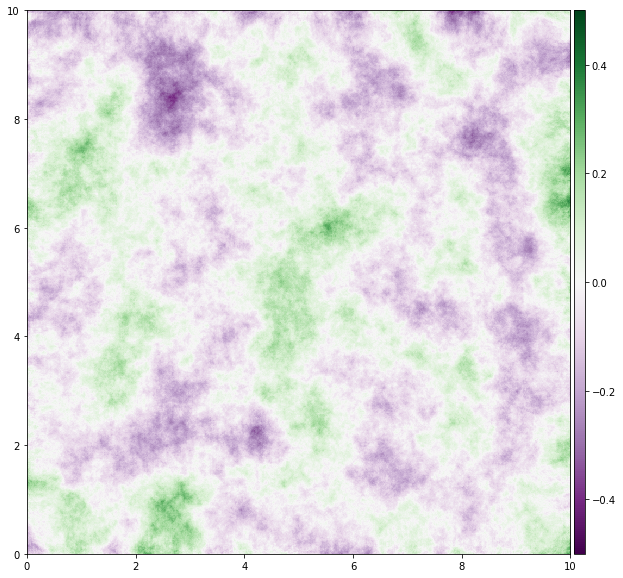

In [4]:
max_altitude = .5  # maximum altitude [m]
tau = .6  # the smoothing parameter in order to create hills and valeys

# create terrain
x_terrain = np.linspace(0, 10, 1001, endpoint=True)
y_terrain = np.linspace(0, 10, 1001, endpoint=True)
x_terrain, y_terrain = np.meshgrid(x_terrain, y_terrain)
try:
    z_terrain = np.load("data/terrain-%.2f.npz" % 0.6)["terrain"] * 1000 * max_altitude
except IOError:
    z_terrain = np.random.randn(*x_terrain.shape) / 50
    terrain = np.zeros_like(z_terrain)
    
    for i in xrange(terrain.shape[0]):
        print "%04d / %04d" % (i + 1, terrain.shape[0]),
        for j in xrange(terrain.shape[1]):
            k = np.sqrt(np.square(x_terrain[i, j] - x_terrain) + np.square(y_terrain[i, j] - y_terrain)) < tau
            terrain[i, j] = z_terrain[k].mean()
            if j % 20 == 0:
                print ".",
        print ""

    np.savez_compressed("terrain-%.2f.npz" % tau, terrain=terrain)
    z_terrain = terrain

plt.figure("Uneven terrain", figsize=(10, 10))
plot_terrain(z_terrain, max_altitude).show()

In [ ]:
def encode(theta, phi, Y, P, A, theta_t=0., phi_t=0., nb_tb1=8, sigma=np.deg2rad(13), shift=np.deg2rad(40)):
    alpha = (phi + np.pi/2) % (2 * np.pi) - np.pi
    phi_tb1 = np.linspace(0., 2 * np.pi, nb_tb1, endpoint=False)  # TB1 preference angles

    # Input (POL) layer -- Photo-receptors
    s_1 = Y * (np.square(np.sin(A - alpha)) + np.square(np.cos(A - alpha)) * np.square(1. - P))
    s_2 = Y * (np.square(np.cos(A - alpha)) + np.square(np.sin(A - alpha)) * np.square(1. - P))
    r_1, r_2 = np.sqrt(s_1), np.sqrt(s_2)
    r_pol = (r_1 - r_2) / (r_1 + r_2 + eps)

    # Tilting (CL1) layer
    d_cl1 = (np.sin(shift - theta) * np.cos(theta_t) +
             np.cos(shift - theta) * np.sin(theta_t) *
             np.cos(phi - phi_t))
    gate = np.power(np.exp(-np.square(d_cl1) / (2. * np.square(sigma))), 1)
    w = -float(nb_tb1) / (2. * float(n)) * np.sin(phi_tb1[np.newaxis] - alpha[:, np.newaxis]) * gate[:, np.newaxis]
    r_tb1 = r_pol.dot(w)

    return r_tb1


def turn(x, y, yaw, theta, phi, theta_s, phi_s, flow, noise=0.):
    sky.theta_s, sky.phi_s = theta_s, phi_s
    Y, P, A = sky(theta, phi + yaw, noise=noise)
    # Y, P, A = get_sky_cues(theta, phi + yaw, theta_s, phi_s, noise=noise)
    r_tb1 = encode(theta, phi, Y, P, A)[::-1]
    _, yaw = decode_sph(r_tb1)
    # yaw = phi_s - yaw
    # motor = net(r_tb1, flow)
    net(yaw, flow)
    yaw = (yaw + np.pi) % (2 * np.pi) - np.pi
    v = np.array([np.sin(yaw), np.cos(yaw)]) * route.dx


def get_3d_direction(x, y, yaw, tau=.06):
    # create point cloud
    i = np.sqrt(np.square(x - x_terrain) + np.square(y - y_terrain)) < tau
    points = np.array([x_terrain[i], y_terrain[i], z_terrain[i]]).T
    if points.shape[0] == 0:
        return 0., 0.
    # print points.shape,
    # compute centred coordinates and run SVD
    _, _, vh = np.linalg.svd(points - points.mean(axis=0))
    # unitary normal vector
    u = vh.conj().transpose()[:, -1]
    p = sph2vec(np.pi / 2, yaw, zenith=True)
    pp = p - p.dot(u) / np.square(np.linalg.norm(u)) * u
    theta_p, phi_p, _ = vec2sph(pp, zenith=True)
    return theta_p - np.pi/2, phi_p - yaw


In [ ]:
# sensor design
n = 60
omega = 56
theta, phi, fit = angles_distribution(n, float(omega))
theta_t, phi_t = 0., 0.

# sun position
seville_obs.date = datetime(2018, 6, 21, 9, 0, 0)
sun.compute(seville_obs)
theta_s = np.array([np.pi/2 - sun.alt])
phi_s = np.array([(sun.az + np.pi) % (2 * np.pi) - np.pi])

# ant-world
noise = 0.0
ttau = .06
dx = 1e-02
# world = load_world()
routes = load_routes()
flow = dx * np.ones(2) / np.sqrt(2)
max_theta = 0.

stats = {
    "max_alt": [],
    "noise": [],
    "opath": [],
    "ipath": [],
    "d_x": [],
    "d_c": [],
    "tau": []
}

for max_altitude in [.0, .1, .2, .3, .4, .5]:
    for ni, noise in enumerate([0.0, 0.2, 0.4, 0.6, 0.8, .97]):
    
        # stats
        d_x = []  # logarithmic distance
        d_c = []
        tau = []  # tortuosity
        ri = 0
    
        for route in routes[::2]:
            net = CX(noise=0., pontin=False)
            net.update = True
    
            # outward route
            route.condition = Hybrid(tau_x=dx)
            oroute = route.reverse()
            x, y, yaw = [(x0, y0, yaw0) for x0, y0, _, yaw0 in oroute][0]
            opath = [[x, y, yaw]]
    
            v = np.zeros(2)
            tb1 = []
            
            for _, _, _, yaw in oroute:
                theta_t, phi_t = get_3d_direction(opath[-1][0], opath[-1][1], yaw, tau=ttau)
                max_theta = max_theta if max_theta > np.absolute(theta_t) else np.absolute(theta_t)
                theta_n, phi_n = tilt(theta_t, phi_t, theta, phi + yaw)
    
                sky.theta_s, sky.phi_s = theta_s, phi_s
                Y, P, A = sky(theta_n, phi_n, noise=noise)
    
                r_tb1 = encode(theta, phi, Y, P, A)
                yaw0 = yaw
                _, yaw = np.pi - decode_sph(r_tb1) + phi_s
                
                net(yaw, flow)
                yaw = (yaw + np.pi) % (2 * np.pi) - np.pi
                v = np.array([np.sin(yaw), np.cos(yaw)]) * route.dx
                opath.append([opath[-1][0] + v[0], opath[-1][1] + v[1], yaw])
                tb1.append(net.tb1)
            opath = np.array(opath)
    
            yaw -= phi_s
    
            # inward route
            ipath = [[opath[-1][0], opath[-1][1], opath[-1][2]]]
            L = 0.  # straight distance to the nest
            C = 0.  # distance towards the nest that the agent has covered
            SL = 0.
            TC = 0.
            tb1 = []
            tau.append([])
            d_x.append([])
            d_c.append([])
    
            while C < 15:
                theta_t, phi_t = get_3d_direction(ipath[-1][0], ipath[-1][1], yaw, tau=ttau)
                theta_n, phi_n = tilt(theta_t, phi_t, theta, phi + yaw)
    
                sky.theta_s, sky.phi_s = theta_s, phi_s
                Y, P, A = sky(theta_n, phi_n, noise=noise)
    
                r_tb1 = encode(theta, phi, Y, P, A)
                _, yaw = np.pi - decode_sph(r_tb1) + phi_s
                motor = net(yaw, flow)
                yaw = (ipath[-1][2] + motor + np.pi) % (2 * np.pi) - np.pi
                v = np.array([np.sin(yaw), np.cos(yaw)]) * route.dx
                ipath.append([ipath[-1][0] + v[0], ipath[-1][1] + v[1], yaw])
                tb1.append(net.tb1)
                L = np.sqrt(np.square(opath[0][0] - ipath[-1][0]) + np.square(opath[0][1] - ipath[-1][1]))
                C += route.dx
                d_x[-1].append(L)
                d_c[-1].append(C)
                tau[-1].append(L / C)
                if C <= route.dx:
                    SL = L
                if TC == 0. and len(d_x[-1]) > 50 and d_x[-1][-1] > d_x[-1][-2]:
                    TC = C
    
            ipath = np.array(ipath)
            d_x[-1] = np.array(d_x[-1]) / SL * 100
            d_c[-1] = np.array(d_c[-1]) / TC * 100
            tau[-1] = np.array(tau[-1])
    
            ri += 1
            
            stats["max_alt"].append(max_altitude)
            stats["noise"].append(noise)
            stats["opath"].append(opath)
            stats["ipath"].append(ipath)
            stats["d_x"].append(d_x)
            stats["d_c"].append(d_c)
            stats["tau"].append(tau)
        
np.savez_compressed("data/pi-stats.npz", **stats)